In [1]:
## import all necessary libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


# Preprocess data

In [2]:
## create variables for image directories

train = './chest_xray/train'
train_normal = './chest_xray/train/NORMAL'
train_pneumonia = './chest_xray/train/PNEUMONIA'

test = './chest_xray/test'
test_normal = './chest_xray/test/NORMAL'
test_pneumonia = './chest_xray/test/PNEUMONIA'

val = './chest_xray/val'
val_normal = './chest_xray/val/NORMAL'
val_pneumonia = './chest_xray/val/PNEUMONIA'

In [3]:
## checking to see how many images are in training, test, validation sets

print('There are', len(os.listdir(train_normal)), 'normal images in training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in training set')

There are 1341 normal images in training set
There are 3875 pneumonia images in training set


In [4]:
print('There are', len(os.listdir(test_normal)), 'normal images in test set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in test set')

There are 234 normal images in test set
There are 390 pneumonia images in test set


In [5]:
print('There are', len(os.listdir(val_normal)), 'normal images in validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in validation set')

There are 8 normal images in validation set
There are 8 pneumonia images in validation set


In [65]:
## reshape images to all be the same size, use image data augmentation on training set 

train_generator = ImageDataGenerator(rescale=1./255,
                                     shear_range=0.2,
                                     zoom_range=0.2).flow_from_directory(
                    train,
                    target_size=(120, 120),
                    batch_size=5216,
                    class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    test,
                    target_size=(120, 120),
                    batch_size=624,
                    class_mode='binary')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    val,
                    target_size=(120, 120),
                    batch_size=16,
                    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
## create the data sets

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
## taking a look at pictures of normal and pneumonia lungs

normal = []
pneumonia = []

for num in range(50):
    if train_labels[num] == 0:
        normal.append(train_images[num])
    else:
        pneumonia.append(train_images[num])

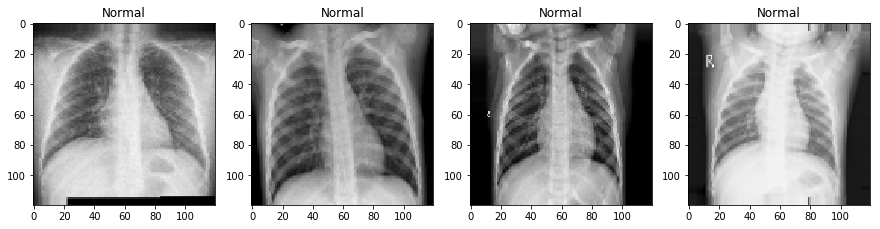

In [9]:
plt.figure(figsize=(15, 6))
for n in range(4):
    plt.subplot(1, 4, n+1)
    plt.title('Normal')
    plt.imshow(normal[n]);

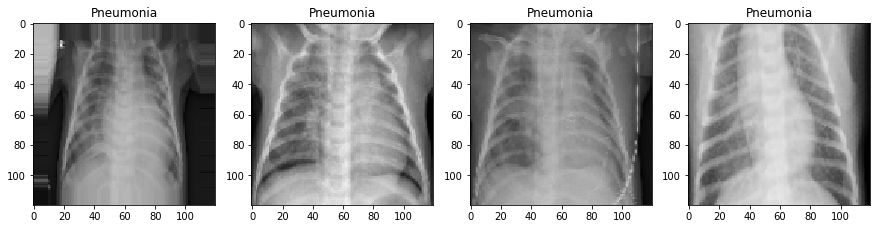

In [10]:
plt.figure(figsize=(15, 6))
for n in range(4):
    plt.subplot(1, 4, n+1)
    plt.title('Pneumonia')
    plt.imshow(pneumonia[n+7]);

Just from a quick glance, normal lungs look much more clear than lungs with pneumonia. We'll see if the neural networks can pick up on the differences between both.

In [11]:
## check shape of data

print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (5216, 120, 120, 3)
train_labels shape: (5216,)
test_images shape: (624, 120, 120, 3)
test_labels shape: (624,)
val_images shape: (16, 120, 120, 3)
val_labels shape: (16,)


In [12]:
## reshape images to get one input feature vector

train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

(5216, 43200)
(624, 43200)
(16, 43200)


# Baseline Model

In [2]:
## build a baseline model

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(43200, )))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               11059456  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 11,104,833
Trainable params: 11,104,833
Non-trainable params: 0
_________________________________________________________________


In [124]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

histoire = model.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=64,
                     validation_data=(val_img, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/50
5216/5216 [==============================] - 8s 2ms/step - loss: 0.5598 - acc: 0.7381 - val_loss: 0.6256 - val_acc: 0.6875
Epoch 2/50
5216/5216 [==============================] - 6s 1ms/step - loss: 0.5185 - acc: 0.7611 - val_loss: 0.6106 - val_acc: 0.6875
Epoch 3/50
5216/5216 [==============================] - 6s 1ms/step - loss: 0.4552 - acc: 0.7924 - val_loss: 0.6022 - val_acc: 0.7500
Epoch 4/50
5216/5216 [==============================] - 6s 1ms/step - loss: 0.3893 - acc: 0.8311 - val_loss: 0.5682 - val_acc: 0.6875
Epoch 5/50
5216/5216 [==============================] - 6s 1ms/step - loss: 0.3590 - acc: 0.8445 - val_loss: 0.7794 - val_acc: 0.6250
Epoch 6/50
5216/5216 [==============================] - 6s 1ms/step - loss: 0.3203 - acc: 0.8683 - val_loss: 0.4698 - val_acc: 0.8125
Epoch 7/50
5216/5216 [==============================] - 6s 1ms/step - loss: 0.2923 - acc: 0.8748 - val_loss: 0.8458 - val_acc: 0.6250
Epoch 8/50
5216/

In [125]:
results_train = model.evaluate(train_img, train_y)

5216/5216 [==============================] - 2s 452us/step


In [126]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 0s 456us/step


In [127]:
results_train

[0.14239542254823848, 0.9426763803680982]

In [128]:
results_test

[0.4017349924796667, 0.8381410256410257]

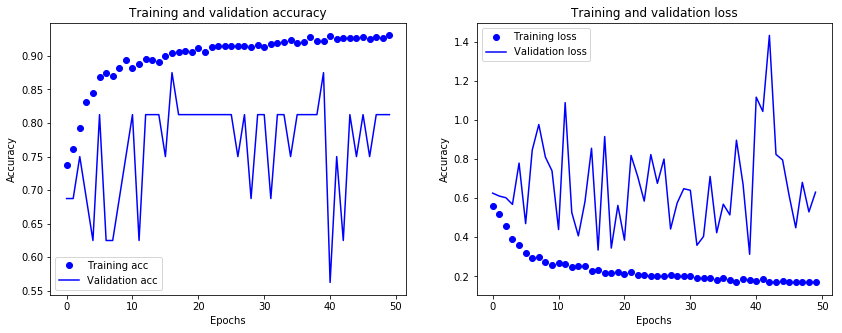

In [129]:
acc = histoire.history['acc']
val_acc = histoire.history['val_acc']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Baseline model with training accuracy of 97% and a testing accuracy of 84%. Testing accuracy is not great so we'll build some CNN's to see if we can improve our performance.

# Building a Convolutional Neural Network

In [66]:
## remake train generator with smaller batch size because we'll be using fit_generator for future models

train_generator = ImageDataGenerator(rescale=1./255, 
                                     shear_range=0.2,
                                     zoom_range=0.2).flow_from_directory(
                    train,
                    target_size=(120, 120),
                    batch_size=32,
                    class_mode='binary')

Found 5216 images belonging to 2 classes.


In [4]:
## build a baseline CNN

cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(128, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

cnn1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [5]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total para

In [127]:
history1 = cnn1.fit_generator(train_generator, 
                              steps_per_epoch = 163,
                              epochs = 20,
                              validation_data = val_generator)

Epoch 1/20
163/163 [==============================] - 89s 544ms/step - loss: 0.3250 - acc: 0.8616 - val_loss: 0.6337 - val_acc: 0.8125
Epoch 2/20
163/163 [==============================] - 89s 544ms/step - loss: 0.2147 - acc: 0.9170 - val_loss: 0.6744 - val_acc: 0.6875
Epoch 3/20
163/163 [==============================] - 90s 553ms/step - loss: 0.1882 - acc: 0.9233 - val_loss: 0.8160 - val_acc: 0.6875
Epoch 4/20
163/163 [==============================] - 90s 554ms/step - loss: 0.1678 - acc: 0.9340 - val_loss: 0.8099 - val_acc: 0.6875
Epoch 5/20
163/163 [==============================] - 87s 534ms/step - loss: 0.1406 - acc: 0.9477 - val_loss: 1.0090 - val_acc: 0.6875
Epoch 6/20
163/163 [==============================] - 90s 553ms/step - loss: 0.1656 - acc: 0.9373 - val_loss: 0.7596 - val_acc: 0.6875
Epoch 7/20
163/163 [==============================] - 92s 561ms/step - loss: 0.1328 - acc: 0.9503 - val_loss: 1.0433 - val_acc: 0.6875
Epoch 8/20
163/163 [==============================] - 8

In [128]:
cnn1.evaluate(train_images, train_y)

5216/5216 [==============================] - 17s 3ms/step


[0.09173885255229254, 0.9658742331288344]

In [129]:
cnn1.evaluate(test_images, test_y)

624/624 [==============================] - 2s 3ms/step


[0.463150774821257, 0.8685897435897436]

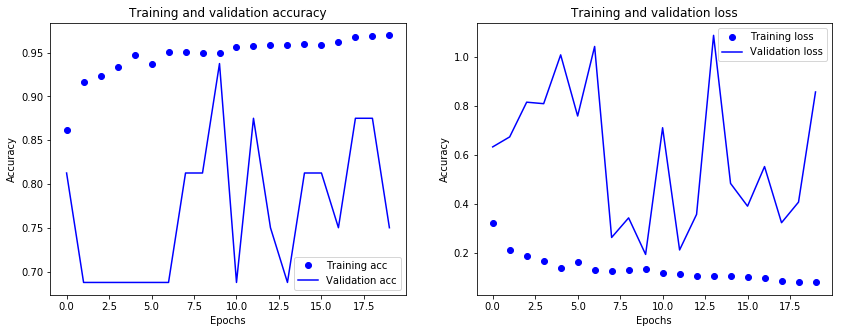

In [248]:
## graph training/validation accuracy and loss through epochs

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [137]:
## calculate confusion matrix and evaluation metrics

preds = cnn1.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

print('\nTRAIN METRIC ----------------------')
print(f'Train acc: {np.round((history1.history["acc"][-1])*100, 2)}%')

CONFUSION MATRIX ------------------
[[154  80]
 [  2 388]]

TEST METRICS ----------------------
Accuracy: 86.85897435897436%
Precision: 82.90598290598291%
Recall: 99.48717948717949%
F1-score: 90.44289044289043%
Specificity: 0.6581196581196581%

TRAIN METRIC ----------------------
Train acc: 96.97%


Building a CNN performs better than a baseline neural network but not by much with a 3% increase in performance over the baseline model. The CNN has testing accuracy of 87% compared to the baseline models 84%. 

We want to maximize our recall and specificity score with more weight placed on recall. Minimizing false negatives is important for this problem because we don't want to misdiagnose a patient with pneumonia. The recall for this model is extremely high at 99% however the specificity is low at 66% due to the high number of false positives.

Next we'll see if adding more layers to our CNN improves model performance.

# CNN with extra layers

In [6]:
## build another CNN with 2 more convolutional layers, 2 more hidden layers, and using dropout regularization

cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(1024, activation='relu'))
cnn2.add(layers.Dropout(0.3))
cnn2.add(layers.Dense(512, activation='relu'))
cnn2.add(layers.Dropout(0.3))
cnn2.add(layers.Dense(128, activation='relu'))
cnn2.add(layers.Dropout(0.3))
cnn2.add(layers.Dense(1, activation='sigmoid'))

cnn2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [8]:
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 116, 116, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)       73856     
__________

In [145]:
history2 = cnn2.fit_generator(train_generator, 
                              steps_per_epoch = 163,
                              epochs = 20,
                              validation_data = val_generator)

Epoch 1/20
163/163 [==============================] - 89s 549ms/step - loss: 0.4126 - acc: 0.8234 - val_loss: 0.8846 - val_acc: 0.5625
Epoch 2/20
163/163 [==============================] - 89s 544ms/step - loss: 0.2409 - acc: 0.9015 - val_loss: 1.0560 - val_acc: 0.6250
Epoch 3/20
163/163 [==============================] - 89s 546ms/step - loss: 0.1929 - acc: 0.9281 - val_loss: 2.0589 - val_acc: 0.5625
Epoch 4/20
163/163 [==============================] - 88s 539ms/step - loss: 0.1711 - acc: 0.9339 - val_loss: 1.4989 - val_acc: 0.6250
Epoch 5/20
163/163 [==============================] - 89s 545ms/step - loss: 0.1584 - acc: 0.9379 - val_loss: 1.2067 - val_acc: 0.5625
Epoch 6/20
163/163 [==============================] - 89s 544ms/step - loss: 0.1461 - acc: 0.9469 - val_loss: 0.8663 - val_acc: 0.5625
Epoch 7/20
163/163 [==============================] - 88s 539ms/step - loss: 0.1497 - acc: 0.9467 - val_loss: 1.3581 - val_acc: 0.6250
Epoch 8/20
163/163 [==============================] - 8

In [80]:
cnn2.evaluate(train_images, train_y)

5216/5216 [==============================] - 73s 14ms/step


[0.07539062985887557, 0.9683665644171779]

In [81]:
cnn2.evaluate(test_images, test_y)

624/624 [==============================] - 8s 13ms/step


[0.2643996942310761, 0.9342948717948718]

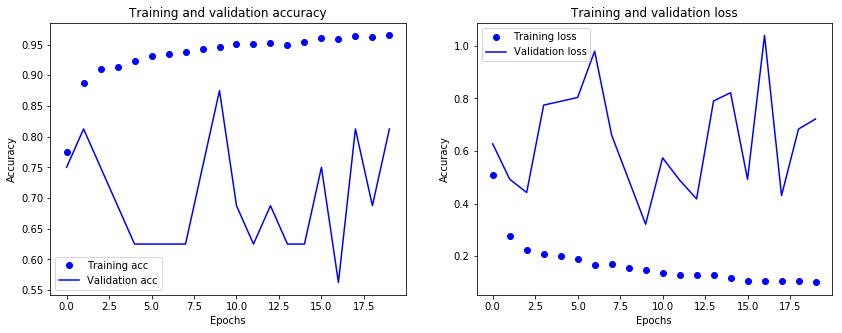

In [82]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [75]:
preds = cnn2.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

print('\nTRAIN METRIC ----------------------')
print(f'Train acc: {np.round((history2.history["acc"][-1])*100, 2)}%')

CONFUSION MATRIX ------------------
[[199  35]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 93.42948717948718%
Precision: 91.64677804295943%
Recall: 98.46153846153847%
F1-score: 94.93201483312731%
Specificity: 85.04273504273505%

TRAIN METRIC ----------------------
Train acc: 96.49%


Adding extra layers and using dropout regularization increased accuracy by 6% from the previous CNN model. This model performs extremely well with an accuracy of 93%. Recall dropped by 1% however specificity increased from 66% to 85% showing a large improvement over our previous model.

# Using Transfer Learning with VGG16

Next we'll use transfer learning by using a pretrained model and running our data through it to see if our evaluation metrics increase. We'll be using the VGG16 model which has been pretrained on over a million images from the ImageNet database. 

We'll begin by using the VGG16 model as a simple feature extractor by freezing the convolution blocks so their weights dont get updated as they model goes through each epoch.

In [9]:
input_tensor = layers.Input(shape=(120, 120, 3))
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

output = vgg16.layers[-1].output
output = layers.Flatten()(output)
vgg16 = models.Model(vgg16.input, output)

for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [152]:
## checking to see that the layers have been frozen and cannot be trained

pd.set_option('max_colwidth', -1)
layers1 = [(layer, layer.name, layer.trainable) for layer in vgg16.layers]
pd.DataFrame(layers1, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001B08CFEBD68>,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0x000001B08CFEBE48>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001B08D023908>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001B08D026E10>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001B08CFEBC50>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001B08CF8D320>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001B08CF82E10>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001B08CF821D0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001B08D006080>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001B08D00A1D0>,block3_conv3,False


In [10]:
model_vgg = models.Sequential()
model_vgg.add(vgg16)
model_vgg.add(layers.Dense(512, activation='relu', input_dim=vgg16.output_shape[1]))
model_vgg.add(layers.Dense(1, activation='sigmoid'))

model_vgg.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [11]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4608)              14714688  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 17,075,009
Trainable params: 2,360,321
Non-trainable params: 14,714,688
_________________________________________________________________


In [154]:
history3 = model_vgg.fit_generator(train_generator,
                               steps_per_epoch=163,
                               epochs=20,
                               validation_data=val_generator)

Epoch 1/20
163/163 [==============================] - 343s 2s/step - loss: 0.2067 - acc: 0.9178 - val_loss: 0.3707 - val_acc: 0.8750
Epoch 2/20
163/163 [==============================] - 333s 2s/step - loss: 0.1407 - acc: 0.9438 - val_loss: 0.3160 - val_acc: 0.8750
Epoch 3/20
163/163 [==============================] - 333s 2s/step - loss: 0.1371 - acc: 0.9467 - val_loss: 0.2338 - val_acc: 0.8750
Epoch 4/20
163/163 [==============================] - 346s 2s/step - loss: 0.1162 - acc: 0.9576 - val_loss: 0.3540 - val_acc: 0.9375
Epoch 5/20
163/163 [==============================] - 348s 2s/step - loss: 0.1202 - acc: 0.9548 - val_loss: 0.5530 - val_acc: 0.7500
Epoch 6/20
163/163 [==============================] - 333s 2s/step - loss: 0.0987 - acc: 0.9611 - val_loss: 0.6549 - val_acc: 0.7500
Epoch 7/20
163/163 [==============================] - 332s 2s/step - loss: 0.1069 - acc: 0.9561 - val_loss: 0.3769 - val_acc: 0.9375
Epoch 8/20
163/163 [==============================] - 333s 2s/step - 

In [155]:
model_vgg.evaluate(train_images, train_y)

5216/5216 [==============================] - 318s 61ms/step


[0.08604967973246438, 0.9662576687116564]

In [156]:
model_vgg.evaluate(test_images, test_y)

624/624 [==============================] - 38s 61ms/step


[0.43680212436578214, 0.8862179487179487]

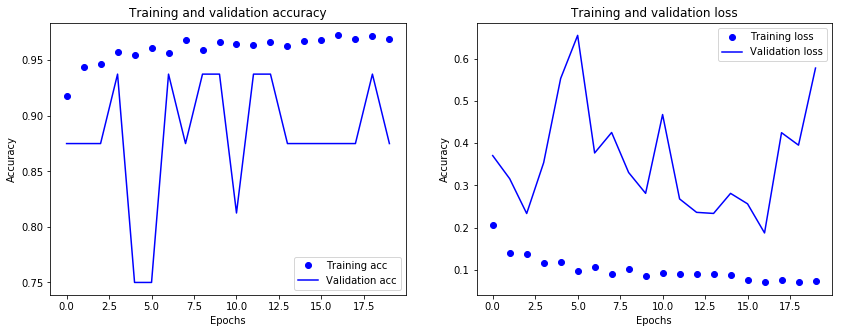

In [250]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [158]:
preds = model_vgg.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

print('\nTRAIN METRIC ----------------------')
print(f'Train acc: {np.round((history3.history["acc"][-1])*100, 2)}%')

CONFUSION MATRIX ------------------
[[166  68]
 [  3 387]]

TEST METRICS ----------------------
Accuracy: 88.62179487179486%
Precision: 85.05494505494505%
Recall: 99.23076923076923%
F1-score: 91.59763313609467%
Specificity: 0.7094017094017094%

TRAIN METRIC ----------------------
Train acc: 96.88%


This model performed worse than our multiple layer CNN with a lower accuracy and lower specificity score. Next we'll unfreeze the last 2 convolution blocks of the VGG16 model and make those blocks trainable. This will allow the model to train on our dataset and hopefully improve upon the performance of previous models.

# Trainable VGG Model

In [12]:
## creating a trainable vgg model

vgg16_trainable = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

output = vgg16_trainable.layers[-1].output
output = layers.Flatten()(output)
vgg16_trainable = models.Model(vgg16_trainable.input, output)


set_trainable=False
for layer in vgg16_trainable.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

vgg16_trainable.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [216]:
## check to see if the convolution blocks we want to train are trainable

pd.set_option('max_colwidth', -1)
layers1 = [(layer, layer.name, layer.trainable) for layer in vgg16_trainable.layers]
pd.DataFrame(layers1, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001B08CFEBD68>,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0x000001B0B2AC3550>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001B0B2BF4160>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001B0B2C80320>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001B0B2B80A58>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001B0B2C94278>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001B0B514DA90>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001B0B514D438>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001B0B5179F98>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001B0B518EC18>,block3_conv3,False


In [13]:
model_vgg_train = models.Sequential()
model_vgg_train.add(vgg16_trainable)
model_vgg_train.add(layers.Dense(512, activation='relu', input_dim=vgg16_trainable.output_shape[1]))
model_vgg_train.add(layers.Dropout(0.3))
model_vgg_train.add(layers.Dense(128, activation='relu'))
model_vgg_train.add(layers.Dropout(0.3))
model_vgg_train.add(layers.Dense(1, activation='sigmoid'))

model_vgg_train.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [14]:
model_vgg_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 4608)              14714688  
_________________________________________________________________
dense_14 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 17,140,289
Trainable params: 15,404,801
Non-trainable params: 1,735,488
________________________________________________________

In [237]:
history4 = model_vgg_train.fit_generator(train_generator,
                               steps_per_epoch=163,
                               epochs=40,
                               validation_data=val_generator)

Epoch 1/40
163/163 [==============================] - 611s 4s/step - loss: 0.2695 - acc: 0.8781 - val_loss: 0.6312 - val_acc: 0.7500
Epoch 2/40
163/163 [==============================] - 604s 4s/step - loss: 0.1339 - acc: 0.9494 - val_loss: 0.4055 - val_acc: 0.8125
Epoch 3/40
163/163 [==============================] - 608s 4s/step - loss: 0.1227 - acc: 0.9549 - val_loss: 0.3523 - val_acc: 0.8125
Epoch 4/40
163/163 [==============================] - 607s 4s/step - loss: 0.1048 - acc: 0.9592 - val_loss: 0.1888 - val_acc: 0.8750
Epoch 5/40
163/163 [==============================] - 601s 4s/step - loss: 0.1008 - acc: 0.9636 - val_loss: 0.1801 - val_acc: 0.8750
Epoch 6/40
163/163 [==============================] - 592s 4s/step - loss: 0.0958 - acc: 0.9643 - val_loss: 0.6717 - val_acc: 0.6875
Epoch 7/40
163/163 [==============================] - 588s 4s/step - loss: 0.0859 - acc: 0.9682 - val_loss: 0.6916 - val_acc: 0.6875
Epoch 8/40
163/163 [==============================] - 588s 4s/step - 

In [239]:
model_vgg_train.evaluate(train_images, train_y)

5216/5216 [==============================] - 323s 62ms/step


[0.030238662309483254, 0.9886886503067485]

In [240]:
model_vgg_train.evaluate(test_images, test_y)

624/624 [==============================] - 38s 62ms/step


[0.5379975193586105, 0.905448717948718]

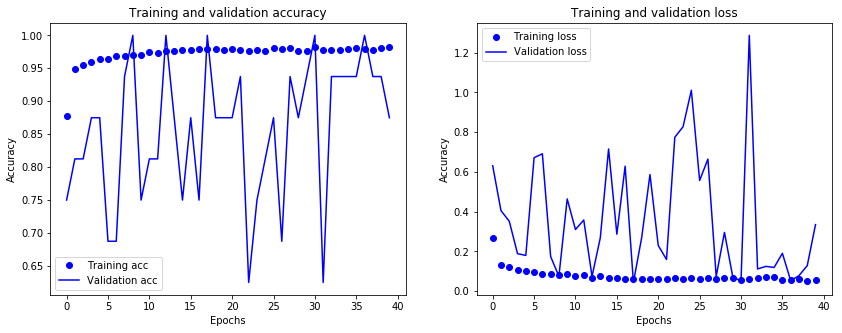

In [246]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [247]:
preds = model_vgg_train.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

print('\nTRAIN METRIC ----------------------')
print(f'Train acc: {np.round((history4.history["acc"][-1])*100, 2)}%')

CONFUSION MATRIX ------------------
[[177  57]
 [  2 388]]

TEST METRICS ----------------------
Accuracy: 90.5448717948718%
Precision: 87.19101123595505%
Recall: 99.48717948717949%
F1-score: 92.93413173652692%
Specificity: 75.64102564102564%

TRAIN METRIC ----------------------
Train acc: 98.16%
